In [ ]:
import os
import itertools
from rosemary import jpt_in_notebook
from llm.submit import submit_job, multiline_to_singleline, shell_scripts_template_slurm

log_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'

test_run = 1
test_run = bool(test_run)

# model_name = 'llama-7b'
model_name = 'llama-7b+lora:r=256:a=256' # includes lora grad norm
# model_name = 'llama-7b_ft=hmv1' # means llama-7b finetuned on tulu humanmix already.
# model_name = 'mistral-7b+lora:r=256:a=256'


sort_by_list = [
    'random_s=0', 'random_s=1', 'random_s=2',
    'log_prob', 'logit_margin', 'el2n_agg=mean',
    'grad_loraB_l2n',
]
# sort_by_list += [
# #     'kmeansl2_emb=grad+rp+loraB_nc=300',
#     'kmeansl2_emb=grad+rp+loraB_nc=1000',
#     'kmeansl2_emb=grad+rp+loraB_nc=3000',
# #     'kmeansl2_emb=text+embedding_nc=300',
#     'kmeansl2_emb=text+embedding_nc=1000',
#     'kmeansl2_emb=text+embedding_nc=3000',
# ]
# sort_by_list += [
#     'dppmap_emb=grad+rp+loraB_k=Kcos', 
#     'dppmap_emb=text+embedding_k=Kcos', 
#     'dppmap_emb=grad+rp+loraB_k=Kcosp', 
#     'dppmap_emb=text+embedding_k=Kcosp',
#     'dppmap_emb=grad+rp+loraB_k=Kcos1np', 
#     'dppmap_emb=text+embedding_k=Kcos1np',
# ]
# dataset_list = ['lima']
# dataset_list = ['flan2022_1m']
dataset_list = ['tulu_v1_mix']
# dataset_list = ['ultrachat']

# sort_by_list = [
#  'log_prob',
#  'el2n_agg=mean',
#  'el2n_agg=l2n',
#  'logit_margin',
# ]
# if 'lora' in model_name:
#     sort_by_list += ['grad_loraB_l2n']
# else:
#     sort_by_list += ['grad_all_l2n', 'grad_qkv_l2n', 'grad_mlp_l2n', 'grad_last_l2n',]
# sort_by_list = ['kmeansl2_emb=grad+rp+loraB_nc=30',
#                 'kmeansl2_emb=text+embedding_nc=30']
# dataset_list = ['lima']


# model_name = 'pythia-1b-deduped'
# model_name = 'pythia-1b-deduped+lora:r=256:a=256'
# dataset_list = ['cot', 'dolly', 'flan_v2', 'lima', 'oasst1']
# # sort_by_list = ['random_s=0', 
# #                 'log_prob', 'logit_margin', 'el2n_agg=mean', 'el2n_agg=l2n', 
# #                 'kmeansl2_nc=3000', 'kmeanscd_nc=3000',
# #                 'grad_loraB_l2n',
# #                 'grad_all_l2n', 'grad_qkv_l2n', 'grad_mlp_l2n', 'grad_last_l2n',
# #                ]
# sort_by_list = ['grad_loraB_l2n']

from note_pruning_analysis import lm_output_dir, data_inds_dir
save_dir = os.path.join(data_inds_dir, model_name)
lm_output_dir = os.path.join(lm_output_dir, model_name)

options_list = itertools.product(dataset_list, sort_by_list)

print('test_run =',test_run)
cmds = []
for dataset, sort_by in options_list:
    cmd = f"""
     python note_pruning.py \
        --dataset {dataset} \
        --sort_by {sort_by} \
        --lm_output_dir {lm_output_dir} \
        --save_dir {save_dir} \
    """.strip()
    cmd = multiline_to_singleline(cmd)
    shell_scripts = shell_scripts_template_slurm.format(
        conda_env='open-instruct',
        cwd=os.getcwd(),
        cmd=cmd,
        log_dir=log_dir,
        save_dir=os.path.join(save_dir, dataset))
    out = submit_job(
        shell_scripts, 
        job_name=f'prune.{dataset}.{sort_by}', 
        nodes=1,
        num_cpus=64, # 32
        cpu_mem=256, # 128
        num_gpus=1,
        gpu_type='v100',
        test_run=test_run,
        job_duration=6,
    )
    cmds.append(cmd)
    print(cmd)
        
print('#cmds: ', len(cmds))


In [ ]:
path = ('/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/'
    'pythia-1b-deduped')


dataset = 'lima'
model_name = 'llama-7b+lora:r=256:a=256'

from note_pruning_analysis import get_lm_output

output = get_lm_output(dataset, model_name, return_text_embedding=False)
output.keys()


In [26]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = os.environ['CUDA_VISIBLE_DEVICES'].split(',')[0] 
    # '0,1,2,3,4,5'
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    
!nvidia-smi

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


1
Tue Oct 31 23:44:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000004:04:00.0 Off |                    0 |
| N/A   39C    P0   143W / 300W |   4724MiB / 32510MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000004:05:00.0 Off |                    0 |
| N/A 

In [27]:
import os
import sys
import numpy as np
import time
import re
import random
import pickle
from tqdm import tqdm 

import pyarrow
import torch
import transformers

from note_pruning import (
    save_to_pickle,
    save_sorted_inds,
    sort_kmeans_dist_to_cluster_centers,
    sort_dpp_map,)

In [28]:
test_run = False
dataset = 'tulu_v1_human_mix'
dataset = 'tulu_v2_human_mix'
dataset = 'flan_v2'
dataset = 'lima'
dataset = 'flan2022_1m'
dataset = 'tulu_v1_mix'

# sort_by = 'random_s=0'
# sort_by = 'kmeansl2_nc=3000'
# sort_by = 'kmeanscd_nc=3000'
sort_by = 'log_prob'
# sort_by = 'dppmap_k=Kcos'
# sort_by = 'dppmap_k=Kcos1np'
# sort_by = 'el2n'
# sort_by = 'grad_norm'
# sort_by = 'kmeansl2_emb=grad+rp+loraB_nc=3000'
# sort_by = 'kmeansl2_emb=text+embedding_nc=3000'
# sort_by = 'dppmap_emb=text+embedding_k=Kcos'


# used for generating model output.
# model_name = 'llama-7b'
# model_name = 'llama-7b_ft=hmv1'
model_name = 'llama-7b+lora:r=256:a=256'


save_dir = f"/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/{model_name}/"
lm_output_dir = f'/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/{model_name}'
save_dir = os.path.join(save_dir, dataset)
os.makedirs(save_dir, exist_ok=True)

In [29]:
save_path = os.path.join(lm_output_dir, f'{dataset}.pkl')
with open(save_path, 'rb') as f:
    d = pickle.load(f)
if test_run:
    d = {k: v[:10000] for k, v in d.items()}

# some entries are nan, impute with mean value.
N = d['text_embedding'].shape[0]
log_prob = np.nan_to_num(d['log_prob'], nan=np.nanmean(d['log_prob'])).squeeze()
print(N)

482145


In [30]:
## the copy in `note_pruning.py` is most up to date
from note_pruning import sort_dpp_map_memefficient

pkl_extra = {}

t0 = time.time()
if any(sort_by.startswith(x) for x in [
        'log_prob', 
        'el2n',  # el2n_agg={l2n|mean}
        'logit_margin', 
        'grad',  # grad_{loraB|qkv|all|last}_l2n
    ]):
    if sort_by not in d:
        print(f'sort_by={sort_by} not in lm_output_dir={lm_output_dir}')
    S = np.nan_to_num(d[sort_by], nan=np.nanmean(d[sort_by])).squeeze()
elif sort_by.startswith('random'):
    match = re.search(r's=(\d+)', sort_by)
    seed = int(match.group(1))
    np.random.seed(seed)
    S = np.random.rand(N)
    assert(S.shape == np.unique(S).shape)
if sort_by.startswith('kmeans'):
    dist_fn = 'l2' if sort_by.startswith('kmeansl2') else 'cd'
    match = re.search(r'nc=(\d+)', sort_by)
    n_clusters = int(match.group(1)) if match else None
    match = re.search(r'emb=([^_]+)', sort_by)
    embed_type = re.sub(r'[+]', '_', match.group(1)) if match else 'text_embedding'
    if embed_type not in set(d.keys()).intersection(set(['text_embedding', 'grad_rp_loraB'])):
        raise ValueError(f'Invalid embed_type = {embed_type}')
    emb = d[embed_type]
    print(f'Running kmeans(n_clusters={n_clusters}) {{ {embed_type} }} to compute {"euclidean" if dist_fn == "l2" else "cosine"} distance to cluster centers.')
    S, kms = sort_kmeans_dist_to_cluster_centers(emb, n_clusters, dist_fn=dist_fn)
    pkl_extra['kmeans'] = kms
elif sort_by.startswith('dpp'):
    match = re.search(r'k=(\w+)', sort_by)
    kernel_type = match.group(1) if match else None
    match = re.search(r'emb=([^_]+)', sort_by)
    embed_type = re.sub(r'[+]', '_', match.group(1)) if match else 'text_embedding'
    if embed_type not in set(d.keys()).intersection(set(['text_embedding', 'grad_rp_loraB'])):
        raise ValueError(f'Invalid embed_type = {embed_type}')
    emb = d[embed_type]
    inds = sort_dpp_map_memefficient(emb, log_prob, kernel_type=kernel_type, torch_compile=False)
t1 = time.time()
print(f'Rank datapoints with {sort_by} took {t1-t0:.2f} seconds.')

# if any(sort_by.startswith(x) for x in ['dpp']):
#     output = {'inds': inds}
#     if pkl_extra:
#         output.update(pkl_extra)
#     save_to_pickle(
#         save_path=os.path.join(save_dir, f'{sort_by}.pkl'),
#         output=output)
# else:
#     save_sorted_inds(save_dir, S, sort_by, extra=pkl_extra, reverse=False)
#     save_sorted_inds(save_dir, S, sort_by, extra=pkl_extra, reverse=True)

#     ## use `note_pruning` to generate scores for curriculum learning.
#     model_name = os.path.basename(lm_output_dir)
#     for pacing_fn in [sort_by, sort_by+'_neg']:
#         curriculum_output_dir = os.path.join('curriculum', model_name, dataset, pacing_fn)
#         os.makedirs(curriculum_output_dir, exist_ok=True)
#         save_path = os.path.join(curriculum_output_dir, 'scores.pkl')
#         output = {'S': -S if pacing_fn.endswith('_neg') else S}
#         save_to_pickle(save_path=save_path, output=output)


Rank datapoints with log_prob took 0.00 seconds.


['data_inds/mistral-7b+lora:r=256:a=256/ultrachat/kmeansl2_emb=grad+rp+loraB_nc=1000_incr.pkl',
 'data_inds/mistral-7b+lora:r=256:a=256/ultrachat/log_prob_incr.pkl',
 'data_inds/mistral-7b+lora:r=256:a=256/ultrachat/logit_margin_incr.pkl',
 'data_inds/mistral-7b+lora:r=256:a=256/ultrachat/kmeansl2_emb=grad+rp+loraB_nc=3000_incr.pkl',
 'data_inds/mistral-7b+lora:r=256:a=256/ultrachat/grad_loraB_l2n_incr.pkl',
 'data_inds/mistral-7b+lora:r=256:a=256/ultrachat/el2n_agg=mean_incr.pkl',
 'data_inds/mistral-7b+lora:r=256:a=256/ultrachat/kmeansl2_emb=text+embedding_nc=3000_incr.pkl',
 'data_inds/mistral-7b+lora:r=256:a=256/ultrachat/kmeansl2_emb=text+embedding_nc=1000_incr.pkl',
 'data_inds/llama-7b+lora:r=256:a=256/ultrachat/kmeansl2_emb=grad+rp+loraB_nc=1000_incr.pkl',
 'data_inds/llama-7b+lora:r=256:a=256/ultrachat/log_prob_incr.pkl',
 'data_inds/llama-7b+lora:r=256:a=256/ultrachat/logit_margin_incr.pkl',
 'data_inds/llama-7b+lora:r=256:a=256/ultrachat/kmeansl2_emb=grad+rp+loraB_nc=3000_in

In [49]:
# ## convert existing pruning scores to curriculum scores

# import glob, os
# import numpy as np
# from note_pruning_analysis import get_sorted_inds

# paths = glob.glob('data_inds/*/*/*.pkl')
# paths = [x for x in paths if 'incr' in x and 'pythia' not in x]
# # path = paths[0]
# # path = 'data_inds/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob_incr.pkl'
# for path in paths:

#     pkl_filename = os.path.basename(path)
#     sort_by = os.path.splitext(pkl_filename)[0]
#     dataset = os.path.basename(os.path.dirname(path))
#     model_name = os.path.basename(os.path.dirname(os.path.dirname(path)))
#     output = {
#         'model_name': model_name, 
#         'dataset': dataset, 
#         'sort_by': sort_by,
#         'pkl_path': path}
#     sorted_inds = get_sorted_inds(dataset, model_name, sort_by)
#     sorted_inds = {k: np.array(v) if v else None for k, v in sorted_inds.items()}
#     if 'S' in sorted_inds and 'inds' in sorted_inds:
#         sorted_inds['S'] = sorted_inds['S'][np.argsort(sorted_inds['inds'])]
#     output.update(sorted_inds)
#     S = output['S']


#     ## use `note_pruning` to generate scores for curriculum learning.
#     for pacing_fn in [sort_by, sort_by+'_neg']:
#         curriculum_output_dir = os.path.join('curriculum', model_name, dataset, pacing_fn)
#         print(curriculum_output_dir)
#         os.makedirs(curriculum_output_dir, exist_ok=True)
#         save_path = os.path.join(curriculum_output_dir, 'scores.pkl')
#         output = {'S': -S if pacing_fn.endswith('_neg') else S}
#         save_to_pickle(save_path=save_path, output=output)

curriculum/mistral-7b+lora:r=256:a=256/ultrachat/kmeansl2_emb=grad+rp+loraB_nc=1000_incr
curriculum/mistral-7b+lora:r=256:a=256/ultrachat/kmeansl2_emb=grad+rp+loraB_nc=1000_incr_neg
curriculum/mistral-7b+lora:r=256:a=256/ultrachat/log_prob_incr
curriculum/mistral-7b+lora:r=256:a=256/ultrachat/log_prob_incr_neg
curriculum/mistral-7b+lora:r=256:a=256/ultrachat/logit_margin_incr
curriculum/mistral-7b+lora:r=256:a=256/ultrachat/logit_margin_incr_neg
curriculum/mistral-7b+lora:r=256:a=256/ultrachat/kmeansl2_emb=grad+rp+loraB_nc=3000_incr
curriculum/mistral-7b+lora:r=256:a=256/ultrachat/kmeansl2_emb=grad+rp+loraB_nc=3000_incr_neg
curriculum/mistral-7b+lora:r=256:a=256/ultrachat/grad_loraB_l2n_incr
curriculum/mistral-7b+lora:r=256:a=256/ultrachat/grad_loraB_l2n_incr_neg
curriculum/mistral-7b+lora:r=256:a=256/ultrachat/el2n_agg=mean_incr
curriculum/mistral-7b+lora:r=256:a=256/ultrachat/el2n_agg=mean_incr_neg
curriculum/mistral-7b+lora:r=256:a=256/ultrachat/kmeansl2_emb=text+embedding_nc=3000_i

curriculum/llama-7b/flan_v2/kmeansl2_nc=1000_incr
curriculum/llama-7b/flan_v2/kmeansl2_nc=1000_incr_neg
curriculum/llama-7b/flan_v2/prob_incr
curriculum/llama-7b/flan_v2/prob_incr_neg
curriculum/llama-7b/flan_v2/el2n_incr
curriculum/llama-7b/flan_v2/el2n_incr_neg
curriculum/llama-7b/flan_v2/kmeansl2_nc=300_incr
curriculum/llama-7b/flan_v2/kmeansl2_nc=300_incr_neg
curriculum/llama-7b/lima/grad_last_l2n_incr
curriculum/llama-7b/lima/grad_last_l2n_incr_neg
curriculum/llama-7b/lima/log_prob_incr
curriculum/llama-7b/lima/log_prob_incr_neg
curriculum/llama-7b/lima/logit_margin_incr
curriculum/llama-7b/lima/logit_margin_incr_neg
curriculum/llama-7b/lima/grad_all_l2n_incr
curriculum/llama-7b/lima/grad_all_l2n_incr_neg
curriculum/llama-7b/lima/el2n_agg=mean_incr
curriculum/llama-7b/lima/el2n_agg=mean_incr_neg
curriculum/llama-7b/lima/grad_mlp_l2n_incr
curriculum/llama-7b/lima/grad_mlp_l2n_incr_neg
curriculum/llama-7b/lima/grad_qkv_l2n_incr
curriculum/llama-7b/lima/grad_qkv_l2n_incr_neg
curricul

curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob
curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob_neg


In [42]:
with open('/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob/scores.pkl', 'rb') as f:
    x = pickle.load(f)
x

{'S': array([-4.287148  , -1.0222019 , -2.8402402 , ..., -0.9446528 ,
        -0.45274076, -0.8406695 ], dtype=float32)}

In [43]:
x['S']-S

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

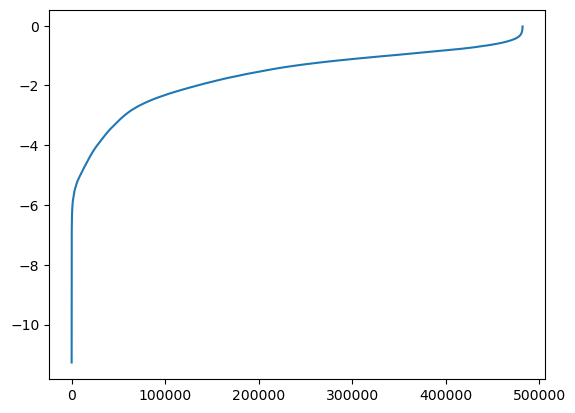

In [22]:
import matplotlib.pyplot as plt

plt.plot(output['S'][output['inds']])

In [ ]:
with open(os.path.join())

In [ ]:
a = np.random.rand(10000,4096).astype(np.float32)
b = np.random.rand(10000,4096).astype(np.float32)
%timeit np.sum(a*b,axis=-1)

In [ ]:
a = np.random.rand(10000,4096).astype(np.float64)
b = np.random.rand(10000,4096).astype(np.float64)
%timeit np.sum(a*b,axis=-1)